# ***Silakan Save a Copy dulu sebelum menggunakan notebook ini!***

Library yang akan digunakan

In [ ]:
#Import all relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# 0. Metode untuk Transformasi Struktur Dataset

## Membuat DataFrame (Format List dengan Koma)

In [ ]:
dat = {'Trx': ['T1', 'T2', 'T3', 'T4', 'T5'],
        'Items': ['B,C,E', 'A,C,D', 'A,C,D,E', 'A,D', 'A,C,E']
        }

In [ ]:
df_sample = pd.DataFrame(dat)
df_sample

,Trx,Items
0,T1,"B,C,E"
1,T2,"A,C,D"
2,T3,"A,C,D,E"
3,T4,"A,D"
4,T5,"A,C,E"


## Transformasi ke Format 1 Item per Baris

In [ ]:
df_sample['Items'].str.get_dummies(sep=',')

,A,B,C,D,E
0,0,1,1,0,1
1,1,0,1,1,0
2,1,0,1,1,1
3,1,0,0,1,0
4,1,0,1,0,1


In [ ]:
df_sample = df_sample.join(df_sample['Items'].str.get_dummies(sep=','))
df_sample

,Trx,Items,A,B,C,D,E
0,T1,"B,C,E",0,1,1,0,1
1,T2,"A,C,D",1,0,1,1,0
2,T3,"A,C,D,E",1,0,1,1,1
3,T4,"A,D",1,0,0,1,0
4,T5,"A,C,E",1,0,1,0,1


#1. Persiapan Data#

## Upload Dataset

Upload file `data_transaksi_retail.xlsx`

(bisa langsung, atau melalui  Mount Drive)

##Membaca Data Set dan Eksplorasi Data##

In [ ]:
data=pd.read_excel('data_transaksi_retail.xlsx')

In [ ]:
data

,Kode Transaksi,Nama Barang,Quantity
0,#1,Kaos,1
1,#1,Shampo Biasa,1
2,#1,Sepatu Sport merk Z,1
3,#1,Serum Vitamin,1
4,#1,Baju Renang Pria Dewasa,1
...,...,...,...
33663,#3450,Flat Shoes Ballerina,1
33664,#3450,Sepatu Sandal Anak,1
33665,#3450,Sepatu Kulit Casual,1
33666,#3450,Celana Jogger Casual,1


In [ ]:
data.head()

,Kode Transaksi,Nama Barang,Quantity
0,#1,Kaos,1
1,#1,Shampo Biasa,1
2,#1,Sepatu Sport merk Z,1
3,#1,Serum Vitamin,1
4,#1,Baju Renang Pria Dewasa,1


In [ ]:
# Cek struktur dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33668 entries, 0 to 33667
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Kode Transaksi  33668 non-null  object
 1   Nama Barang     33668 non-null  object
 2   Quantity        33668 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 789.2+ KB


In [ ]:
# Cek apakah ada data kosong
data.isna().sum()

Kode Transaksi    0
Nama Barang       0
Quantity          0
dtype: int64

In [ ]:
# Ada berapa unique product?
print(data['Nama Barang'].nunique())
data['Nama Barang'].unique()

69


array(['Kaos', 'Shampo Biasa', 'Sepatu Sport merk Z', 'Serum Vitamin',
       'Baju Renang Pria Dewasa', 'Baju Renang Wanita Dewasa',
       'Baju Kaos Olahraga', 'Celana Jogger Casual', 'Dompet Card Holder',
       'Celana Jeans Sobek Wanita', 'Blouse Denim', 'Baju Batik Wanita',
       'Hair and Scalp', 'Minyak Rambut', 'Wedges Hitam',
       'Sepatu Sandal Anak', 'Tas Sekolah Anak Perempuan',
       'Baju Kemeja Putih', 'Dompet Flip Cover', 'Hair Tonic',
       'Baju Kaos Anak - Superheroes', 'Celana Pendek Casual',
       'Jeans Jumbo', 'Celana Pendek Jeans', 'Sepatu Sekolah Hitam W',
       'Tas Ransel Mini', 'Dompet Kulit Pria', 'Hair Dryer',
       'Flat Shoes Ballerina', 'Tas Sekolah Anak Laki-laki',
       'Cover Koper', 'Gembok Koper', 'Sweater Top Panjang', 'Tank Top',
       'Atasan Kaos Putih', 'Atasan Baju Belang', 'Shampo Anti Dandruff',
       'Tas Pinggang Wanita', 'Koper Fiber', 'Sepatu Sport merk Y',
       'Dompet STNK Gantungan', 'Cream Whitening', 'Celana Tactical

In [ ]:
# Apa produk yang paling sering dibeli?
data['Nama Barang'].value_counts()

Shampo Biasa               2075
Serum Vitamin              1685
Baju Batik Wanita          1312
Baju Kemeja Putih          1255
Celana Jogger Casual       1136
                           ... 
Tali Ban Ikat Pinggang       27
Pelembab                     24
Stripe Pants                 19
Tas Kosmetik                 11
Celana Jeans Sobek Pria       9
Name: Nama Barang, Length: 69, dtype: int64

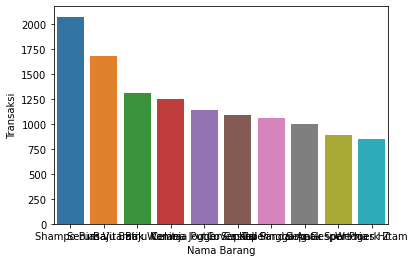

In [ ]:
# buat visualisasi top 10 barang laris

df_laris = data['Nama Barang'].value_counts().reset_index()
df_laris.columns = ['Nama Barang', 'Transaksi']
sns.barplot(x='Nama Barang', y='Transaksi', data = df_laris.head(10))

In [ ]:
# Cek jumlah transaksi
df_summary = data.groupby('Kode Transaksi').agg({'Nama Barang': ['count'], 'Quantity': ['sum']}).reset_index()
df_summary

,Kode Transaksi,Nama Barang,Quantity
,,count,sum
0,#1,9,9
1,#10,11,11
2,#100,11,11
3,#1000,11,11
4,#1001,12,12
...,...,...,...
3445,#995,8,8
3446,#996,13,13
3447,#997,8,8


In [ ]:
df_summary.columns = ['Kode Transaksi','Jenis Barang', 'Jumlah Barang']
df_summary

,Kode Transaksi,Jenis Barang,Jumlah Barang
0,#1,9,9
1,#10,11,11
2,#100,11,11
3,#1000,11,11
4,#1001,12,12
...,...,...,...
3445,#995,8,8
3446,#996,13,13
3447,#997,8,8
3448,#998,12,12


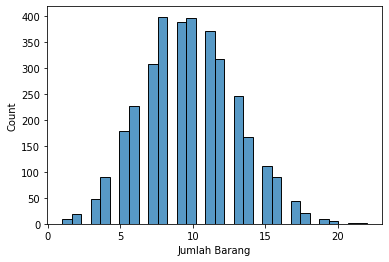

In [ ]:
# Distribusi Jumlah Barang per Transaksi
sns.histplot(df_summary['Jumlah Barang'])

## Pre-processing

Kita perlu untuk mengubah formatnya agar tiap kolom merepresentasikan 1 item, dengan nilai 1 (ada) atau 0 (tidak ada)

In [ ]:
data_basket = (data.groupby(['Kode Transaksi', 'Nama Barang'])['Quantity'].count()\
                                      .unstack().reset_index().fillna(0)\
                                      .set_index('Kode Transaksi'))

In [ ]:
data_basket

Nama Barang,Atasan Baju Belang,Atasan Kaos Putih,Baju Batik Wanita,Baju Kaos Anak - Karakter Kartun,Baju Kaos Anak - Superheroes,Baju Kaos Olahraga,Baju Kemeja Putih,Baju Renang Anak Perempuan,Baju Renang Pria Anak-anak,Baju Renang Pria Dewasa,...,Tas Multifungsi,Tas Pinggang Wanita,Tas Ransel Mini,Tas Sekolah Anak Laki-laki,Tas Sekolah Anak Perempuan,Tas Tangan,Tas Travel,Tas Waist Bag,Wedges Hitam,Woman Ripped Jeans
Kode Transaksi,,,,,,,,,,,,,,,,,,,,,
#1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
#100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#995,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
#996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
#997,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Show a subset of columns
data_basket.iloc[:,[0,1,2,3,4,5,6,7]].head()

Nama Barang,Atasan Baju Belang,Atasan Kaos Putih,Baju Batik Wanita,Baju Kaos Anak - Karakter Kartun,Baju Kaos Anak - Superheroes,Baju Kaos Olahraga,Baju Kemeja Putih,Baju Renang Anak Perempuan
Kode Transaksi,,,,,,,,
#1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
#10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
#100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
#1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Melakukan proses encoding -> Mengubah data kebentuk angka, agar sistem atau komputer dapat memahami informasi dari dataset
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

data_sets = data_basket.applymap(encode_units)
data_sets.head(5)

Nama Barang,Atasan Baju Belang,Atasan Kaos Putih,Baju Batik Wanita,Baju Kaos Anak - Karakter Kartun,Baju Kaos Anak - Superheroes,Baju Kaos Olahraga,Baju Kemeja Putih,Baju Renang Anak Perempuan,Baju Renang Pria Anak-anak,Baju Renang Pria Dewasa,...,Tas Multifungsi,Tas Pinggang Wanita,Tas Ransel Mini,Tas Sekolah Anak Laki-laki,Tas Sekolah Anak Perempuan,Tas Tangan,Tas Travel,Tas Waist Bag,Wedges Hitam,Woman Ripped Jeans
Kode Transaksi,,,,,,,,,,,,,,,,,,,,,
#1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
#10,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
#100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#1000,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
#1001,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,0


Tujuan dalam encoding ini adalah memastikan jika barang kurang dari sama dengan 0 maka keranjang tersebut bernilai 0 dan jika lebih dari 1 maka nilainya adalah 1, sehingga jika sebuah nota membeli barang A sebanyak 10 buah maka hanya akan dihitung 1. 

#2. Association Rules Mining

## Membuat Frequent Itemsets

In [ ]:
frequent_itemsets = apriori(data_sets, min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.118841,(Atasan Kaos Putih)
1,0.380290,(Baju Batik Wanita)
2,0.121159,(Baju Kaos Anak - Karakter Kartun)
3,0.115942,(Baju Kaos Anak - Superheroes)
4,0.363768,(Baju Kemeja Putih)
...,...,...
98,0.132754,"(Baju Kemeja Putih, Shampo Biasa, Serum Vitamin)"
99,0.105217,"(Tali Pinggang Gesper Pria, Shampo Biasa, Cela..."
100,0.102899,"(Celana Jogger Casual, Shampo Biasa, Serum Vit..."
101,0.101449,"(Shampo Biasa, Cover Koper, Serum Vitamin)"


## Membuat Association Rules

In [ ]:
rules0_1 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules0_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Baju Batik Wanita),(Shampo Biasa),0.380290,0.601449,0.246377,0.647866,1.077175,0.017652,1.131815
1,(Baju Kemeja Putih),(Shampo Biasa),0.363768,0.601449,0.243768,0.670120,1.114175,0.024980,1.208167
2,(Blouse Denim),(Shampo Biasa),0.182319,0.601449,0.129275,0.709062,1.178922,0.019620,1.369882
3,(Celana Jeans Sobek Wanita),(Shampo Biasa),0.241739,0.601449,0.206087,0.852518,1.417440,0.060693,2.702368
4,(Celana Jogger Casual),(Shampo Biasa),0.329275,0.601449,0.208406,0.632923,1.052329,0.010363,1.085740
5,(Celana Pendek Casual),(Shampo Biasa),0.185217,0.601449,0.112754,0.608764,1.012161,0.001355,1.018696
6,(Celana Pendek Jeans),(Shampo Biasa),0.235072,0.601449,0.146667,0.623921,1.037363,0.005283,1.059753
7,(Celana Tactical ),(Shampo Biasa),0.175072,0.601449,0.115652,0.660596,1.098340,0.010355,1.174267
8,(Cover Koper),(Shampo Biasa),0.314783,0.601449,0.195942,0.622468,1.034946,0.006616,1.055673
9,(Dompet Card Holder),(Shampo Biasa),0.223768,0.601449,0.144928,0.647668,1.076846,0.010342,1.131181


## Eksplorasi Frequent Itemsets

In [ ]:
frequent_itemsets = apriori(data_sets, min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.118841,(Atasan Kaos Putih)
1,0.380290,(Baju Batik Wanita)
2,0.121159,(Baju Kaos Anak - Karakter Kartun)
3,0.115942,(Baju Kaos Anak - Superheroes)
4,0.363768,(Baju Kemeja Putih)
...,...,...
98,0.132754,"(Baju Kemeja Putih, Shampo Biasa, Serum Vitamin)"
99,0.105217,"(Tali Pinggang Gesper Pria, Shampo Biasa, Cela..."
100,0.102899,"(Celana Jogger Casual, Shampo Biasa, Serum Vit..."
101,0.101449,"(Shampo Biasa, Cover Koper, Serum Vitamin)"


In [ ]:
# Menentukan size tiap itemset
frequent_itemsets['k'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,k
0,0.118841,(Atasan Kaos Putih),1
1,0.380290,(Baju Batik Wanita),1
2,0.121159,(Baju Kaos Anak - Karakter Kartun),1
3,0.115942,(Baju Kaos Anak - Superheroes),1
4,0.363768,(Baju Kemeja Putih),1
...,...,...,...
98,0.132754,"(Baju Kemeja Putih, Shampo Biasa, Serum Vitamin)",3
99,0.105217,"(Tali Pinggang Gesper Pria, Shampo Biasa, Cela...",3
100,0.102899,"(Celana Jogger Casual, Shampo Biasa, Serum Vit...",3
101,0.101449,"(Shampo Biasa, Cover Koper, Serum Vitamin)",3


In [ ]:
# Mengurutkan dari yang support tertinggi
frequent_itemsets.sort_values('support', ascending=False)

,support,itemsets,k
29,0.601449,(Shampo Biasa),1
27,0.488406,(Serum Vitamin),1
1,0.380290,(Baju Batik Wanita),1
4,0.363768,(Baju Kemeja Putih),1
8,0.329275,(Celana Jogger Casual),1
...,...,...,...
77,0.102609,"(Hair and Scalp, Serum Vitamin)",2
69,0.102609,"(Tali Pinggang Gesper Pria, Cover Koper)",2
101,0.101449,"(Shampo Biasa, Cover Koper, Serum Vitamin)",3
96,0.101159,"(Baju Batik Wanita, Shampo Biasa, Sepatu Sanda...",3


In [ ]:
# Filter frequent itemset dengan item tertentu
frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: 'Celana Jogger Casual' in x)]

,support,itemsets,k
8,0.329275,(Celana Jogger Casual),1
41,0.115362,"(Baju Batik Wanita, Celana Jogger Casual)",2
47,0.131884,"(Celana Jogger Casual, Baju Kemeja Putih)",2
59,0.117101,"(Celana Jogger Casual, Sepatu Sport merk Z)",2
60,0.157681,"(Celana Jogger Casual, Serum Vitamin)",2
61,0.208406,"(Celana Jogger Casual, Shampo Biasa)",2
62,0.116232,"(Tali Pinggang Gesper Pria, Celana Jogger Casual)",2
100,0.102899,"(Celana Jogger Casual, Shampo Biasa, Serum Vit...",3


## Praktek

Dengan data `df_sample` di atas, coba cari semua frequent itemsets dengan kriteria:
- minimum support 0.3
- mengandung item Ceri
- Diurutkan dari support tertinggi

Ada berapa itemset yang ditemukan? Berapa nilai support terkecil yang terambil?

In [ ]:
# tulis code di sini
new_df = df_sample['Items'].str.get_dummies(sep=',')
f_items_new_df = apriori(new_df, min_support=0.3, use_colnames=True)
f_items_new_df[f_items_new_df['itemsets'].apply(lambda x: 'C' in x)].sort_values('support', ascending=False)

,support,itemsets
1,0.8,(C)
4,0.6,"(C, A)"
8,0.6,"(C, E)"
7,0.4,"(D, C)"
9,0.4,"(D, C, A)"
10,0.4,"(C, A, E)"


Dengan frequent itemset di atas, buatlah association rules dengan confidence >= 0.7

Ada berapa rules yang diperoleh? Berapa nilai lift tertinggi?

In [ ]:
# tulis code di sini
new_rules0_1 = association_rules(f_items_new_df, metric="confidence", min_threshold=0.7)
new_rules0_1.sort_values('lift', ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(D),(A),0.6,0.8,0.6,1.00,1.2500,0.12,inf
5,(E),(C),0.6,0.8,0.6,1.00,1.2500,0.12,inf
6,"(D, C)",(A),0.4,0.8,0.4,1.00,1.2500,0.08,inf
7,"(A, E)",(C),0.4,0.8,0.4,1.00,1.2500,0.08,inf
3,(A),(D),0.8,0.6,0.6,0.75,1.2500,0.12,1.6
4,(C),(E),0.8,0.6,0.6,0.75,1.2500,0.12,1.6
0,(C),(A),0.8,0.8,0.6,0.75,0.9375,-0.04,0.8
1,(A),(C),0.8,0.8,0.6,0.75,0.9375,-0.04,0.8


# Kesimpulan

Algoritma apriori adalah salah satu algoritma yang merupakan penerapan praktis dari Market Basket Analysis (MBA). Algoritma ini digunakan untuk menganalisa banyaknya kombinasi produk yang terjadi di dalam transaksi ritel, yang akan sulit dan lama jika dilakukan secara manual.

Secara teknis, algoritma apriori akan mencari tingkat asosiasi antar item di dalam banyak kombinasi kelompok data secara otomatis. Kombinasi ini juga bisa disusun dengan suatu aturan (rule) asosiasi "Jika membeli ini produk A maka akan membeli produk B", sehingga algoritma ini dikategorikan sebagai Association Rules di ranah machine learning.

Dengan menemukan paket produk yang asosiasinya kuat, Anda sebagai seorang data scientist dapat menyarankan kepada bisnis dapat melakukan berbagai action item seperti membuat paket produk dengan penawaran khusus, mendekatkan produk-produk tersebut saling berdekatan dalam satu rak, mengeluarkan rekomendasi produk di sistem e-commerce, mengurangi masalah stok, dan lain-lain.